**Deep Learning (COSC2779)  Assignment 1**

Salina Bharthu (S3736867)

Aim:
The aim of this assignment is to develope a deep convolutional neural network(CNN) to identify the head pose given an image of a person.

This Notebook outlines the implementation of deep CNN Model for the classification of tilt angles of images.

In [2]:
# set this to print all output from a cell in notebook, not just the most recent one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings   #suppress warnings
warnings.filterwarnings("ignore")

In [3]:
#Import useful Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix

#**Data Extraction and Exploration**

Dataset: 
The Dataset contains images of headpose captured from the camera placed on front. The headpose is quantified in two different labels, that are, tilt(vertical angle of the head) and pan(horizontal angle of the head). 
The images are having labels of tilt assigned in seperate csv data files along with person_id and series_id.  

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
#Extracting Image Files from drive
!cp /content/drive/'My Drive'/'Colab Notebooks'/modified_data.zip .
!unzip -q -o modified_data.zip -d Imagedata
!rm modified_data.zip

In [6]:
#Extracting csv files containing metadata about images
data = pd.read_csv("../content/drive/My Drive/Colab Notebooks/train_data.csv")
testdata = pd.read_csv("../content/drive/My Drive/Colab Notebooks/test_data.csv")

In [7]:
print("Data frame Size:", len(data) ,"\n")
print("Tilt Labels:")
data.tilt.unique()
data["tilt"] = data["tilt"].astype(str) 

print("\n\nPerson_id Distribution in training dataframe")
data.person_id.value_counts()

print("\n\nSeries Distribution in training dataframe")
data.series.value_counts()

Data frame Size: 2325 

Tilt Labels:


array([-15,   0,  15,  30, -60, -30,  90,  60, -90])



Person_id Distribution in training dataframe


15    186
13    186
11    186
9     186
7     186
5     186
14    186
12    186
10    186
8     186
6     186
4     186
3      93
Name: person_id, dtype: int64



Series Distribution in training dataframe


2    1209
1    1116
Name: series, dtype: int64

Text(0.5, 1.0, 'tilt')

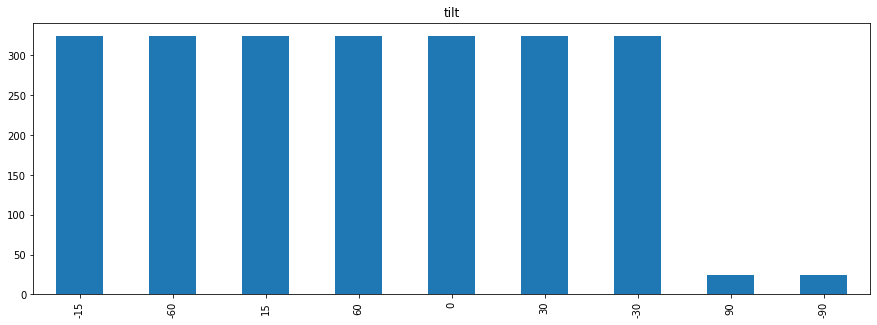

In [8]:
#Plotting the Distribution of target labels
categorical_features = ["tilt"]
fig = plt.figure(figsize=(10,10))
for i, categorical_feature in enumerate(data[categorical_features]):
    data[categorical_feature].value_counts().plot(kind = "bar", figsize = (15,5)).set_title(categorical_feature)
fig.show()

The above plot shows that, except two target variable class 90 and -90, all other target variable classes are balanced with equal data distribution. This can be addressed by adding  in using Augmented Image data.

<Figure size 1440x1440 with 0 Axes>

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Tilt: -90')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Tilt: 0')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Tilt: 30')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Tilt: 60')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Tilt: -30')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Tilt: -60')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Tilt: 15')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Tilt: 90')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Tilt: -15')

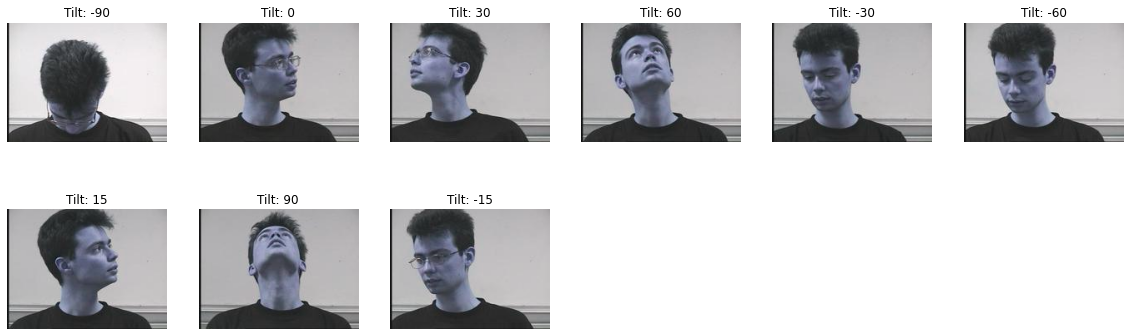

In [9]:
#Extract image for each Label of Tilt Angle

tilt_label = set(data['tilt'])
plt.figure(figsize=(20, 20))
i = 1 #counter
path = "/content/Imagedata/modified_data/"

for label in tilt_label:
    fullpath = path + data.loc[list(data['tilt']).index(label)][0] #path to first image of each label
    image = cv2.imread(fullpath)
    plt.subplot(6, 6, i)
    plt.axis('off')
    plt.title("Tilt: {0}".format(label, list(data['tilt']).count(label)))
    i += 1
    plt.imshow(image, cmap="gray")

plt.show()


In [10]:
#test dataframe exploration
len(testdata)
testdata.person_id.unique()
testdata.series.unique()

465

array([2, 3, 1])

array([1, 2])


Image Size: (144, 192)


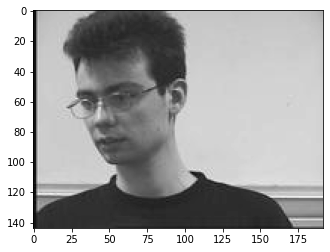

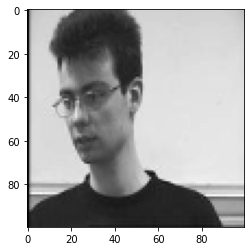

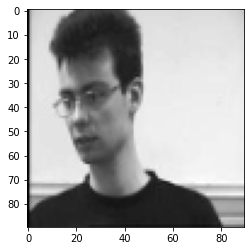

In [11]:
#Finding suitable Image size to feed into network
image_name = data['filename'][0]
full_path = "/content/Imagedata/modified_data/" + image_name
image = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
print("\nImage Size:" , image.shape)

plt.imshow(image, cmap = "gray")
plt.show()

image = cv2.resize(image, (100,100))  
plt.imshow(image, cmap = "gray")
plt.show()

image = cv2.resize(image, (90,90))
plt.imshow(image, cmap = "gray")
plt.show()

#**Tilt Classification Model Implementation**



**Data Preparation**


*   Initially, the train and test dataframes are seprated using person_id. The train dataframe is further splitted into train-validation datasets of 80-20 ratio.

*   While splitting the train and validation data, stratify is used on the target column in-order to ensure equalt distribution of images from all classes.

*   The train and validation dataframe is further used to extract training and validation images using filenaes. This is implemented using keras ImageDataGenerator at runtime.
*   The images are extracted using target_size of 100*100, which is finalized after experimenting with different sizes









In [12]:
#Train-validation-test dataframe split
train_df  = data.loc[data['person_id'] < 13]
test_df = data.loc[data['person_id'] >= 13]
train_df.tilt.unique()

train_df_tilt, val_df_tilt = train_test_split(train_df, test_size= 0.2, stratify = train_df['tilt'], random_state = 22)

array(['-15', '0', '15', '30', '-60', '-30', '90', '60', '-90'],
      dtype=object)

In [13]:
#Preparing Training and Validation datasets
path = "/content/Imagedata/modified_data"
BATCH_SIZE = 16 

def tilt_train_generator():
    datagen = ImageDataGenerator(data_format='channels_last', rescale=1./255)
    tilt_train_generator = datagen.flow_from_dataframe(
        dataframe = train_df_tilt,
        directory = path,
        x_col = "filename",
        y_col = "tilt",
        target_size = (100, 100),
        batch_size = 1,
        color_mode = "grayscale",
        shuffle = False,
        class_mode = 'categorical')
    return tilt_train_generator

def tilt_val_generator():
    datagen = ImageDataGenerator(data_format='channels_last', rescale=1./255)
    tilt_val_generator = datagen.flow_from_dataframe(
        dataframe = val_df_tilt,
        directory = path,
        x_col = "filename",
        y_col = "tilt",
        target_size = (100, 100),
        batch_size = 1,
        color_mode = "grayscale",
        shuffle = False,
        class_mode = 'categorical')
    return tilt_val_generator

train_dataset = tf.data.Dataset.from_generator(tilt_train_generator, output_types=(tf.float32, tf.float32), output_shapes=([1,100,100,1], [1,9]))
vaidation_dataset = tf.data.Dataset.from_generator(tilt_val_generator,output_types=(tf.float32, tf.float32), output_shapes=([1,100,100,1], [1,9]))

VAL_DATA_LEN = val_df_tilt.shape[0]
TRAIN_DATA_LEN = train_df_tilt.shape[0]

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = image[0,:]
  label = label[0,:]
  return image, label

def augment(image,label):
  image,label = convert(image, label)
  image = tf.image.resize_with_crop_or_pad(image, 110, 110) # Add 10 pixels of padding
  image = tf.image.random_brightness(image, max_delta=0.3) # Random brightness
  image = tf.image.random_crop(image, size=[100, 100, 1]) # crop back to 100*100
  
  return image,label

In [15]:
augmented_train_batches = train_dataset.take(TRAIN_DATA_LEN).cache()
augmented_train_batches = augmented_train_batches.shuffle(TRAIN_DATA_LEN).map(augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True)

In [16]:
non_augmented_train_batches = train_dataset.take(TRAIN_DATA_LEN).cache()
non_augmented_train_batches = non_augmented_train_batches.shuffle(TRAIN_DATA_LEN).map(convert, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True)

In [17]:
validation_batches = vaidation_dataset.take(VAL_DATA_LEN).cache()
validation_batches =validation_batches.map(convert, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True)



#**Baseline CNN Model**





*   Initially, developing very basic CNN model for dry run with 2 convolutional layers followed by max pooling layers and fully connected layers at the end for classification of 9 tilt angles
*   The image with input size of 100*100 with depth = 1 (grayscale images) are given as an input to the Convolutional layers
*   Using 'relu' activation for adding non-linearity and 'adam' optimizer for faster convergence and adaptive learning rate
*   Training the base model on Augmented and Non-augmented Datasets with 50 epochs
*   Using categorical_crossentropy and accuracy metrics to evaluate the model performance






In [ ]:
# Function to create Neural Network Model
def base_model_cnn(num_label):
    
    classifier = Sequential()
    
    # Input layer
    classifier.add(Input(shape=(100, 100, 1)))

    # Conv Layer 1
    classifier.add(Conv2D(16, (3, 3), activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv Layer 2 (no pooling)
    classifier.add(Conv2D(32, (3, 3), activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))

    #Fully Connected layer
    classifier.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    classifier.add(Dense(64, activation='relu'))

    #output layer
    classifier.add(Dense(num_label, activation='softmax'))    
    classifier.summary()

    return classifier

In [20]:
UNIQUE_TILT = len(set(train_df_tilt['tilt']))

In [ ]:
base_histories = {}
model_with_aug_tilt = base_model_cnn(UNIQUE_TILT)  
model_with_aug_tilt.compile(optimizer = tf.keras.optimizers.Adam(), loss=tf.losses.CategoricalCrossentropy(),
              metrics=[tf.losses.CategoricalCrossentropy(name='CategoricalCrossentropy'), 'accuracy'])

#On Non Augmented Data
base_histories['Without_Aug_tilt'] = model_with_aug_tilt.fit(non_augmented_train_batches, epochs=50, validation_data=validation_batches, verbose=1, batch_size = BATCH_SIZE)

#On Augmented Data
base_histories['With_Aug_tilt'] = model_with_aug_tilt.fit(augmented_train_batches, epochs=50, validation_data=validation_batches, verbose=1, batch_size = BATCH_SIZE)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16928)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                1083456   
_________________________________________________________________
dense_7 (Dense)              (None, 9)                

In [19]:
#Function to plot validation curves
from itertools import cycle
def plotter(history_hold, metric = 'binary_crossentropy', ylim=[0.0, 2.0]):
  cycol = cycle('bgrcmk')
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0,len(y_val))

    c=next(cycol)

    plt.plot(x_train, y_train, c+'-', label=name+'_train')
    plt.plot(x_train, y_val, c+'--', label=name+'_val')

  plt.legend()
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)

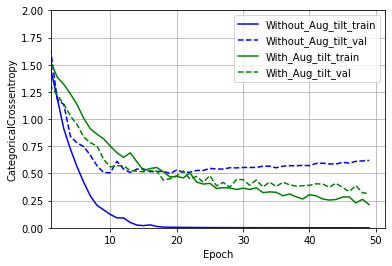

In [ ]:
plotter(base_histories, ylim=[0.0, 2.0], metric = 'CategoricalCrossentropy')

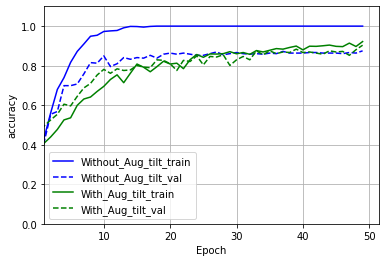

In [ ]:
plotter(base_histories, ylim=[0.0, 1.1], metric = 'accuracy')



*   The above two learning and validation curve shows that model gives very high generalization gap and overfitting of data while using non augmented training batches. Therefore, using augmented training batches for further implementation
*   Also, the augmented batches shows the minor signs of overfitting and fluctuations






**CNN Model Architecture Modifications**

*   L2 Kernel regularizer is added to Convolution layer to deal with the minor overfitting. In this task, L2 regularizer adds small penalty value to the weights matrix of the nodes. Initially 0.001 regularization coefficient value is use which is optimized to obtain well-fitted model. The regularization penalty is very small as there is no obvious sign of overfitting at the moment but by further increasing the model complexity, it can be useful to avoid the issue of overfitting.

*   In fully connected layers, dropout layer is added. It zero out the activation of randomly chosen nuerons as per the dropout rate. The dropout rate is initially chosen as 0.5 and further optimized. It can help reduce the runtime and avoid the overfitting.

*   To enhance the accuracy, 1 (Convolution + max pooling) layers are added. The filter size of the layers near the input layer is small and incremently changing in later layers.

*   One additional fully connected layer is added. The number of nuerons are optimized later. 

*   The 'adam' optimizer is used with decaying learnng rate at run time. The adam optimizer itself uses adaptive learning rate to update the weights of each parameter, however, using exponential decay helps to speed up the optimization process.

* Here, the evaluation metrics precision and recall are added to gain better understanding of multi class classification

In [41]:
def get_cnn_model(num_label, STEPS_PER_EPOCH, filters = 8, kernel_size = 3, pool_size = 2, lambda_reg = 0.01, dropout = 0.5, units = 64, initial_lr= 0.001):
  classifier = Sequential()

  # input
  classifier.add(Input(shape=(100, 100, 1)))

  # Conv Layer 1
  classifier.add(Conv2D(filters, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lambda_reg)))
  classifier.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

  # Conv Layer 2 (no pooling)
  classifier.add(Conv2D(filters*2, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lambda_reg)))
  classifier.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

  # Conv Layer 3
  classifier.add(Conv2D(filters*4, (kernel_size, kernel_size), activation='relu', padding='same'))
  classifier.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

  # MLP
  classifier.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
  classifier.add(Dropout(dropout))
  classifier.add(Dense(units, activation='relu'))
  classifier.add(Dense(units/2, activation='relu'))

  #output layer
  classifier.add(Dense(num_label, activation='softmax'))
  
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(initial_lr, decay_steps=STEPS_PER_EPOCH*1000, decay_rate=1, staircase=False)

  classifier.compile(optimizer = tf.keras.optimizers.Adam(lr_schedule),
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=[tf.losses.CategoricalCrossentropy(name = 'CategoricalCrossentropy'), 'accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

  classifier.save_weights('modelCNN.h5')
  classifier.summary()
  
  return classifier

In [42]:
model_histories = {}
model_tilt = get_cnn_model(UNIQUE_TILT, TRAIN_DATA_LEN)  

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 100, 100, 8)       80        
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 50, 50, 16)        1168      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 25, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4608)             

Initial model run with 100 epochs

In [ ]:
model_histories['With_augmentation_Tilt'] = model_tilt.fit(augmented_train_batches, epochs=100, validation_data=validation_batches, verbose=1)

Epoch 1/100
88/88 [==============================] - 9s 99ms/step - loss: 2.1472 - CategoricalCrossentropy: 2.0604 - accuracy: 0.1548 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 2.0772 - val_CategoricalCrossentropy: 2.0142 - val_accuracy: 0.1364 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/100
88/88 [==============================] - 8s 95ms/step - loss: 2.0406 - CategoricalCrossentropy: 1.9864 - accuracy: 0.2074 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.9922 - val_CategoricalCrossentropy: 1.9435 - val_accuracy: 0.2528 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/100
88/88 [==============================] - 8s 95ms/step - loss: 1.9387 - CategoricalCrossentropy: 1.8933 - accuracy: 0.2528 - precision_1: 0.7143 - recall_1: 0.0071 - val_loss: 1.7606 - val_CategoricalCrossentropy: 1.7174 - val_accuracy: 0.3381 - val_precision_1: 0.8889 - val_recall_1: 0.0227
Epoch 4/100
88/88 [==============================] - 8s 

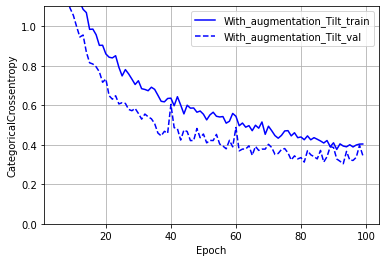

In [ ]:
plotter(model_histories, ylim=[0.0, 1.1], metric = 'CategoricalCrossentropy')

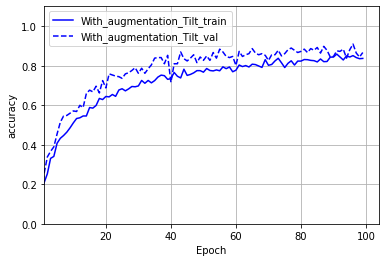

In [ ]:
plotter(model_histories, ylim=[0.0, 1.1], metric = 'accuracy') 

The above validation and training curve shows that the modified CNN architecture generalizes well as validation curve follows training curve well without significant gap, however, the curves are not stabilized yet, therefore training the model with more epochs

In [ ]:
model_histories['With_augmentation_Tilt'] = model_tilt.fit(augmented_train_batches, epochs=150, validation_data=validation_batches, verbose=0)

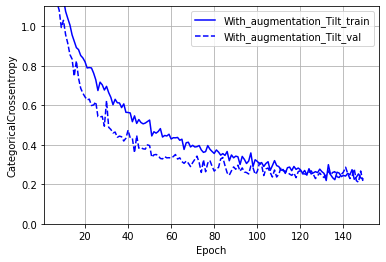

In [ ]:
plotter(model_histories, ylim=[0.0, 1.1], metric = 'CategoricalCrossentropy')

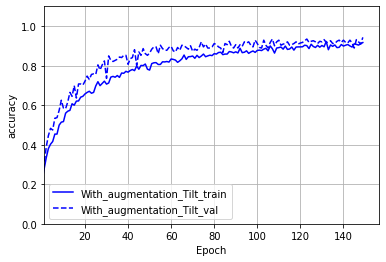

In [ ]:
plotter(model_histories, ylim=[0.0, 1.1], metric = 'accuracy')

The curves look stabilized around 150 epochs.  

#**Parameter Tuning for Tilt Model**



*   To further optimize the model performance, parameter tuning is performed
*   Parameter tuning of batch_size and number of epochs is performed seperated followed by tuning of othre configurable hyper parameters of CNN architecture using randomizedsearch cross validation



In [ ]:
#Preparing datasets for parameter tuning
tilt_df = tilt_train_generator()
tiltX = np.concatenate([tilt_df.next()[0] for i in range(TRAIN_DATA_LEN)])
tilty = np.concatenate([tilt_df.next()[1] for i in range(TRAIN_DATA_LEN)])
#print(tiltX.shape)
#print(tilty.shape)

X_train, X_test, y_train, y_test = train_test_split(tiltX, tilty, test_size = 0.2)

Found 1413 validated image filenames belonging to 9 classes.


The small batch size generally provide rapid learning but with high variance in classification accuracy. The model shows minor fluctuation, therefore, the batch_size is tuned initially. 

In [ ]:
model = KerasClassifier(build_fn = get_cnn_model, verbose = 1)

#set of parameters to be tuned
param_grid = dict(
    epochs = [150],
    batch_size = [16,32],
    num_label = [9],
    TRAIN_DATA_LEN = [TRAIN_DATA_LEN]
  )

#Applying randomized search with cross validation for parameter tuning
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv = 3, n_iter = 5)
grid_result = grid.fit(X_train, y_train)

print("Best parameter set %s" % (grid_result.best_params_))

16
Epoch 1/150
48/48 [==============================] - 4s 76ms/step - loss: 2.2084 - CategoricalCrossentropy: 2.1080 - accuracy: 0.1487 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00
Epoch 2/150
48/48 [==============================] - 4s 77ms/step - loss: 2.0995 - CategoricalCrossentropy: 2.0387 - accuracy: 0.1381 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00
Epoch 3/150
48/48 [==============================] - 4s 77ms/step - loss: 2.0041 - CategoricalCrossentropy: 1.9684 - accuracy: 0.2244 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00
Epoch 4/150
48/48 [==============================] - 4s 77ms/step - loss: 1.8495 - CategoricalCrossentropy: 1.8094 - accuracy: 0.2948 - precision_3: 0.5714 - recall_3: 0.0053
Epoch 5/150
48/48 [==============================] - 4s 78ms/step - loss: 1.6395 - CategoricalCrossentropy: 1.6206 - accuracy: 0.3997 - precision_3: 0.7426 - recall_3: 0.0996
Epoch 6/150
48/48 [==============================] - 4s 76ms/step - loss: 1.5403 - CategoricalCros

The following code block contains hyper parameter tuning of multiple hyper parameters and it takes long execution time. Considerring the resource limitations ,parameter tuning with 50 epochs is implemented. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tiltX, tilty, test_size = 0.2)
model = KerasClassifier(build_fn = get_cnn_model, verbose = 1)
STEPS_PER_EPOCH = TRAIN_DATA_LEN// 32
#set of parameters to be tuned
param_grid = dict(
    epochs = [50],
    initial_lr = [0.1, 0.01, 0.001],
    lambda_reg = [0.1, 0.01, 0.001],
    dropout = [0.3, 0.5],
    kernel_size = [2,3],
    filters = [8, 16, 32],
    pool_size = [2,3],
    units = [64,128],
    num_label = [9],
    STEPS_PER_EPOCH = [STEPS_PER_EPOCH]
  )

#Applying randomized search with cross validation for parameter tuning
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv = 3)
grid_result = grid.fit(X_train, y_train)

print("Best parameter set %s" % (grid_result.best_params_))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 100, 100, 8)       80        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 16)        1168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)             

Using best Param values to train the model for tilt

In [26]:
#{'units': 128, 'pool_size': 3, 'num_label': 9, 'lambda_reg': 0.001, 'kernel_size': 2, 'initial_lr': 0.01, 'filters': 8, 'epochs': 50, 'dropout': 0.3, 'STEPS_PER_EPOCH': 88}
model_tilt_tune = get_cnn_model(9, 88, 8, 2, 3, 0.001, 0.3, 128, 0.01)
tilt_histories = {}
tilt_histories['With_Aug_tilt_tune'] = model_tilt_tune.fit(augmented_train_batches, epochs=150, validation_data=validation_batches, verbose=1)

Epoch 1/150
Found 1413 validated image filenames belonging to 9 classes.
     88/Unknown - 7s 79ms/step - loss: 2.0705 - CategoricalCrossentropy: 2.0602 - accuracy: 0.1605 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00Found 354 validated image filenames belonging to 9 classes.
88/88 [==============================] - 8s 95ms/step - loss: 2.0705 - CategoricalCrossentropy: 2.0602 - accuracy: 0.1605 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 2.0430 - val_CategoricalCrossentropy: 2.0341 - val_accuracy: 0.2386 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/150
88/88 [==============================] - 8s 88ms/step - loss: 1.9584 - CategoricalCrossentropy: 1.9500 - accuracy: 0.2259 - precision_1: 0.6000 - recall_1: 0.0021 - val_loss: 1.7747 - val_CategoricalCrossentropy: 1.7665 - val_accuracy: 0.3324 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/150
88/88 [==============================] - 8s 89ms/step - loss: 1.7381 - CategoricalCrosse

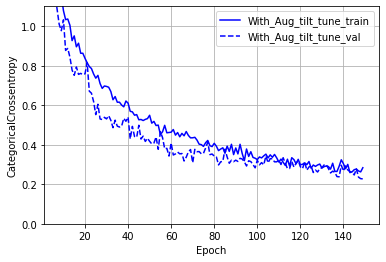

In [27]:
plotter(tilt_histories, ylim=[0.0, 1.1], metric = 'CategoricalCrossentropy')

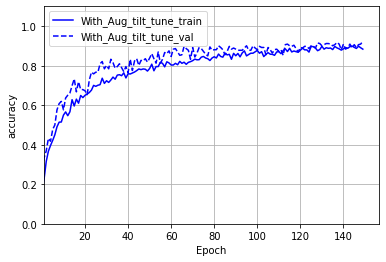

In [29]:
plotter(tilt_histories, ylim=[0.0, 1.1], metric = 'accuracy') 

#**Model Evaluation on Hold-out Test Data**

In [30]:
TEST_DF_LEN = test_df.shape[0]

test_datagen = ImageDataGenerator( data_format='channels_last', rescale=1./255 )
test_generator = test_datagen.flow_from_dataframe(
        dataframe = test_df, 
        directory = path,
        x_col = "filename",
        y_col = "tilt",
        target_size = (100, 100),
        batch_size = 1,
        color_mode = "grayscale",
        shuffle = False,
        class_mode = 'categorical')

pred = model_tilt_tune.predict(test_generator, verbose=1, steps=TEST_DF_LEN)

predicted_class_indices_tilt = np.argmax(pred,axis=1)
labels = (test_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices_tilt]


actual_labels = test_generator.classes
actual_test_labels = [labels2[k] for k in actual_labels]

Found 558 validated image filenames belonging to 9 classes.
558/558 [==============================] - 2s 4ms/step


In [25]:
#Function to display classification report and confusion matrix
def displayConfusionMatrix(pred_y, test_lable, target_names):
    confusion_mat= confusion_matrix(test_lable, pred_y)
    print('Classification Report')
    print(classification_report(test_lable, pred_y, target_names=target_names))
    plt.imshow(confusion_mat, cmap=plt.cm.Greys)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title('Confusion matrix of Hold out Test data')
    plt.colorbar()
    plt.show()

Classification Report
              precision    recall  f1-score   support

         -30       0.46      0.40      0.43        89
          90       0.49      0.58      0.53        66
         -60       0.60      0.75      0.67        63
           0       0.00      0.00      0.00         1
          60       0.50      0.51      0.50        77
          30       0.71      0.45      0.55       122
         -15       0.54      0.68      0.60        62
         -90       0.86      0.92      0.89        73
          15       0.67      0.80      0.73         5

    accuracy                           0.59       558
   macro avg       0.54      0.56      0.54       558
weighted avg       0.60      0.59      0.59       558



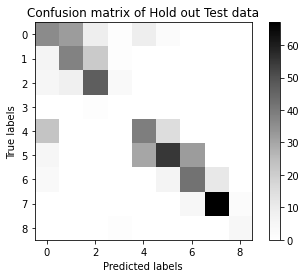

In [32]:
target_names_tilt = set(test_df['tilt'])
displayConfusionMatrix(actual_test_labels, predictions, target_names_tilt)

#**Prediction on unseen Test Data**

In [33]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
final_test_generator = test_datagen.flow_from_dataframe(
    dataframe=testdata,
    directory=path,
    x_col="filename",
    target_size=(100, 100),
    batch_size=1,
    color_mode="grayscale",
    shuffle=False,
    class_mode=None
    )

Found 465 validated image filenames.


In [34]:
pred_tilt = model_tilt_tune.predict(final_test_generator, verbose=1, steps=len(final_test_generator))
final_predicted_tilt_indices = np.argmax(pred_tilt,axis=1)

labels = (test_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
final_predictions = [labels2[k] for k in final_predicted_tilt_indices]

final_df = pd.DataFrame()
final_df['filename'] = testdata['filename']
final_df['tilt'] = final_predictions

465/465 [==============================] - 2s 4ms/step


In [35]:
final_df.head()

,filename,tilt
0,face_33.jpg,60
1,face_2148.jpg,30
2,face_2119.jpg,-15
3,face_1262.jpg,15
4,face_516.jpg,30


In [36]:
#Write Tilt predictions to .csv file
final_df.to_csv('../content/drive/My Drive/Colab Notebooks/s3736867_tilt.csv')